In [120]:
#Import dataframes
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yaml
import os

In [2]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'ggplot2', 'dplyr', 'equatiomatic', 'glmmTMB', 'emmeans')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
#utils = importr("utils")
#utils.chooseCRANmirror(ind=1)
#utils.install_packages(StrVector(packnames))

In [3]:
# Enable cell magic for Rpy2 interface
%load_ext rpy2.ipython

In [4]:
%%R 
# load LMER libraries
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(glmmTMB)
library(emmeans)
#library(equatiomatic) # Not in CRAN anymore need to wait for update here: https://github.com/datalorax/equatiomatic/issues/224


Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
## Load config file
config = yaml.safe_load(open(f"./config/config.yaml"))

# Loading and cleaning dataset

In [13]:
sample_size = config['datasets']['sample_size']
final_data_folder = config['datasets']['final_data_folder']
final_data_filename = config['datasets']['final_data_filename']
final_data_file = f"{final_data_filename}_{sample_size}.pkl"
final_data_location = os.path.join(final_data_folder, final_data_file)
df_raw = pd.read_pickle(final_data_location)

In [205]:
df_raw.columns

Index(['index', 't_id', 'a_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 't_text', '_id.$oid',
       'author.username', 'author.created_at', 'a_name', 't_retweet_count',
       't_reply_count', 't_like_count', 't_quote_count', 'author.location',
       'referenced_tweets', 'attachments.media_keys', 'attachments.media',
       'geo.place_id', 'geo.country', 'geo.full_name', 'geo.id',
       'geo.coordinates.type', 'geo.coordinates.coordinates',
       'attachments.poll_ids', 'author.withheld.country_codes',
       'author.withheld.scope', 'withheld.copyright', 'withheld.country_codes',
       'withheld.scope', 't_event', 'cleaned_text', 'sia_negative',
       'sia_positive', 'sia_neutral', 'sia_compound', 'tb_polarity',
       't_subjectivity', 'rbta_negative', 'rbta_neutral', 'rbta_positive',
       't_polarity', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise', 'top emotion', 'depression', 't_topic', 'Probability',
       'La

In [7]:
# Specify the terms of interest to clean the df from unrelated tweets that only contained those words in URLs and others
terms = ['abortion', 'miscarriage', 'feticide', 'foeticide', 'aborticide', 'stillbirth',
         'early pregnancy loss', 'fetal homicide', 'child destruction']

# Create a pattern to match any of the specified terms
pattern = r'\b(?:{})\b'.format('|'.join(terms))

# Filter the DataFrame based on the pattern
df_raw = df_raw[df_raw['cleaned_text'].str.contains(pattern, case=False, regex=True)]

# Display the resulting DataFrame
print(len(df_raw))

82629


In [17]:
# Rename the rows in the event column
event_labels = {'Miscarriage 21':'WPILRD 2021', 'Miscarriage 22':'WPILRD 2022', 'Abortion 21':'ISAD 2021', 'Abortion 22':'ISAD 2022'}

df_raw['event'] = df_raw['event'].replace(event_labels)

In [18]:
# Create a variable for the event without the year
df_raw['t_type_event'] = np.where(df_raw['event'].isin(['WPILRD 2021','WPILRD 2022']), 'Miscarriage', 'Abortion')

In [10]:
#Rename the rows in the gender column
gender_labels = {'female':'Woman', 'male':'Man', 'neutral':'Unclassified'}

df_raw['gender'] = df_raw['gender'].replace(gender_labels)

In [21]:
#Rename the rows in the gender column
user_labels = {'none':'Normal',
             'blue':'Blue check',
             'business':'Business',
             'government':'Government'}

df_raw['verified_type'] = df_raw['verified_type'].replace(user_labels)


In [22]:
#Create the temporary date column, once new dataframe is created we have to delete the columns
#There was a duplicate column of created_at
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]

#Delete the events that = 0 (they were outside the labels)
df_raw = df_raw[df_raw['event'] != '0']
df_raw.loc[:, 'created_at'] = pd.to_datetime(df_raw['created_at'], format='%d-%m-%y')

#Create the ["year"] column for graphs
df_raw['year'] = pd.DatetimeIndex(df_raw['created_at']).year

#Create the ["hour"] column for graphs
df_raw['date'] = pd.DatetimeIndex(df_raw['created_at']).date

#Create the ["hour"] column for graphs
df_raw['hour'] = pd.DatetimeIndex(df_raw['created_at']).hour

In [216]:
# Rename columns used as features
to_rename = {'id': 't_id', 
             'text': 't_text',
             'author_id': 'a_id',
             'author.name': 'a_name',
             'public_metrics.retweet_count': 't_retweet_count',
             'public_metrics.reply_count': 't_reply_count',
             'public_metrics.like_count': 't_like_count',
             'public_metrics.quote_count': 't_quote_count',
             'followers_count': 'a_followers_count',
             'following_count': 'a_following_count',
             'tweet_count': 'a_tweet_count',
             'listed_count': 'a_listed_count',
             'gender': 'a_gender',
             'total_metrics': 't_total_count',
             'Topic': 't_topic',
             'rbta_compound': 't_polarity',
             'tb_subjectivity': 't_subjectivity',
             'verified_type': 'a_verified_type',
             'event': 't_event',
             'year': 't_year',
             'overall depression': 't_depression',
             'Label': 't_topic_label',
            }
df_raw = df_raw.rename(columns=to_rename)

In [219]:
# Remove tweets where there is no information about the counts
df = df_raw[~df_raw['a_listed_count'].isna() | 
        ~df_raw['a_followers_count'].isna() |
        ~df_raw['a_following_count'].isna() | 
        ~df_raw['a_tweet_count'].isna()]

In [221]:
# Getting the columns to modelise
df = df[['t_id',
         't_text',
         
         't_topic',
         't_topic_label',
         't_retweet_count',
         't_reply_count',
         't_like_count',
         't_quote_count',
         't_total_count',
          't_topic',
         't_polarity',
         't_subjectivity', 
         't_event', 
         't_type_event',
         't_depression',
         't_year',
          'a_id',
         'a_name',
         'a_gender',
         'a_followers_count',
         'a_following_count',
         'a_tweet_count',
         'a_listed_count',
         'a_verified_type',
    ]]

## Analysing authors and tweet counts

In [26]:
# Replace 'column_name' with the name of the column you want to clean
def getting_iqr(col, ):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
   #lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Col value
    #col[(col < lower_bound) | (col > upper_bound)] = pd.NA
    #Bool mask
    #return (col < lower_bound) | (col > upper_bound)
    return (col > upper_bound)

In [27]:
def modified_z_score(data):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad  # 0.6745 is a scaling factor for consistency with the standard Z-score
    return modified_z_scores

# Example usage:
data = [1, 2, 3, 4, 100]  # Replace this with your dataset
z_scores = modified_z_score(data)

# Set a threshold to identify outliers (commonly used threshold is 3.5)
threshold = 3.5
outliers = np.abs(z_scores) > threshold

### Tweets

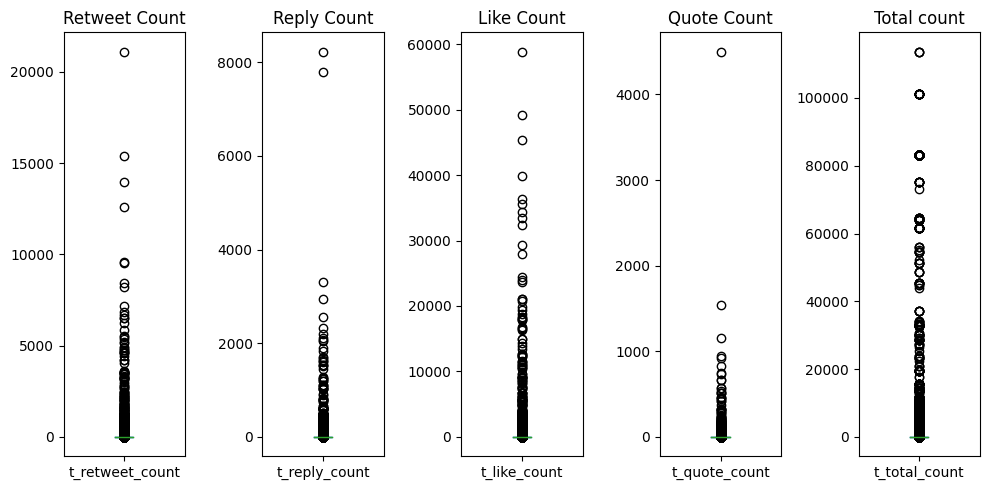

In [28]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=5)
axes = df[['t_retweet_count', 't_reply_count', 't_like_count', 't_quote_count', 't_total_count']].plot(kind='box', subplots=True,legend=False, ax=axs)
# List of plot names (titles) for each subplot
plot_names = ['Retweet Count', 'Reply Count', 'Like Count', 'Quote Count', 'Total count']

# Add plot names to each subplot
for i, ax in enumerate(axes):
    ax.set_title(plot_names[i])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

In [29]:
# Count the number of zeros in each column
zero_counts = df[['t_retweet_count', 't_reply_count', 't_like_count', 't_quote_count', 't_total_count']].apply(lambda col: (col == 0).sum())

# Print the zero counts for each column
for col_name, count in zip(zero_counts.index, zero_counts.values):
    print(f"Number of zeros in '{col_name}': {count} - Proportion: {count/df.shape[0]}")

Number of zeros in 't_retweet_count': 59854 - Proportion: 0.6666295413538859
Number of zeros in 't_reply_count': 69281 - Proportion: 0.7716236384291537
Number of zeros in 't_like_count': 45958 - Proportion: 0.5118615374334529
Number of zeros in 't_quote_count': 79623 - Proportion: 0.8868086338627403
Number of zeros in 't_total_count': 29973 - Proportion: 0.33382709999331744


### Authors

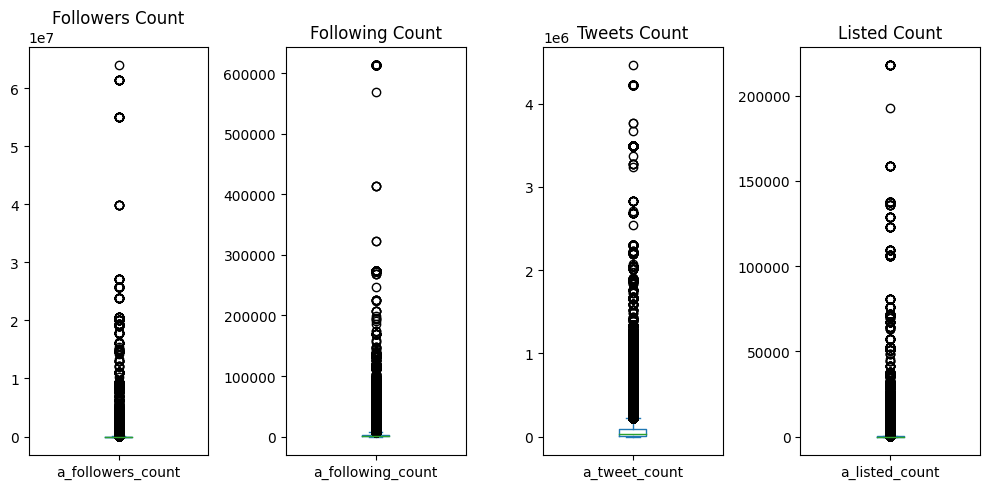

In [30]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=4)
axes = df[['a_followers_count', 
                         'a_following_count', 
                         'a_tweet_count', 
                         'a_listed_count']].plot(kind='box', subplots=True,legend=False, ax=axs)
# List of plot names (titles) for each subplot
plot_names = ['Followers Count', 'Following Count', 'Tweets Count', 'Listed Count']

# Add plot names to each subplot
for i, ax in enumerate(axes):
    ax.set_title(plot_names[i])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

In [31]:
# Count the number of zeros in each column
zero_counts = df[['a_followers_count', 
                         'a_following_count', 
                         'a_tweet_count', 
                         'a_listed_count']].apply(lambda col: (col == 0).sum())

# Print the zero counts for each column
for col_name, count in zip(zero_counts.index, zero_counts.values):
    print(f"Number of zeros in '{col_name}': {count} - Proportion: {count/df.shape[0]}")

Number of zeros in 'a_followers_count': 593 - Proportion: 0.006604593143697235
Number of zeros in 'a_following_count': 1608 - Proportion: 0.01790925088543871
Number of zeros in 'a_tweet_count': 6 - Proportion: 6.682556300536832e-05
Number of zeros in 'a_listed_count': 15206 - Proportion: 0.16935825184327177


In [32]:
correlation_matrix = df[['t_retweet_count',
                         't_reply_count', 
                         't_like_count', 
                         't_quote_count',
                         'a_followers_count', 
                         'a_following_count', 
                         'a_tweet_count', 
                         'a_listed_count']].corr()
correlation_matrix

t_retweet_count  t_reply_count  t_like_count  \
t_retweet_count           1.000000       0.525417      0.914326   
t_reply_count             0.525417       1.000000      0.585482   
t_like_count              0.914326       0.585482      1.000000   
t_quote_count             0.727594       0.544248      0.609229   
a_followers_count         0.033396       0.073515      0.040194   
a_following_count         0.035066       0.021468      0.028977   
a_tweet_count            -0.005120      -0.002966     -0.006096   
a_listed_count            0.033032       0.062456      0.035048   

                   t_quote_count  a_followers_count  a_following_count  \
t_retweet_count         0.727594           0.033396           0.035066   
t_reply_count           0.544248           0.073515           0.021468   
t_like_count            0.609229           0.040194           0.028977   
t_quote_count           1.000000           0.034234           0.026677   
a_followers_count       0.034234           1.000000           0.009781   
a_following_count       0.026677           0.009781           1.000000   
a_tweet_count          -0.000856           0.093199           0.289480   
a_listed_count          0.035986           0.927291           0.026843   

                   a_tweet_count  a_listed_count  
t_retweet_count        -0.005120        0.033032  
t_reply_count          -0.002966        0.062456  
t_like_count           -0.006096        0.035048  
t_quote_count          -0.000856        0.035986  
a_followers_count       0.093199        0.927291  
a_following_count       0.289480        0.026843  
a_tweet_count           1.000000        0.111176  
a_listed_count          0.111176        1.000000

/home/olivier/git/pro/bsc/MiscarriageTwitterAnalysis/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


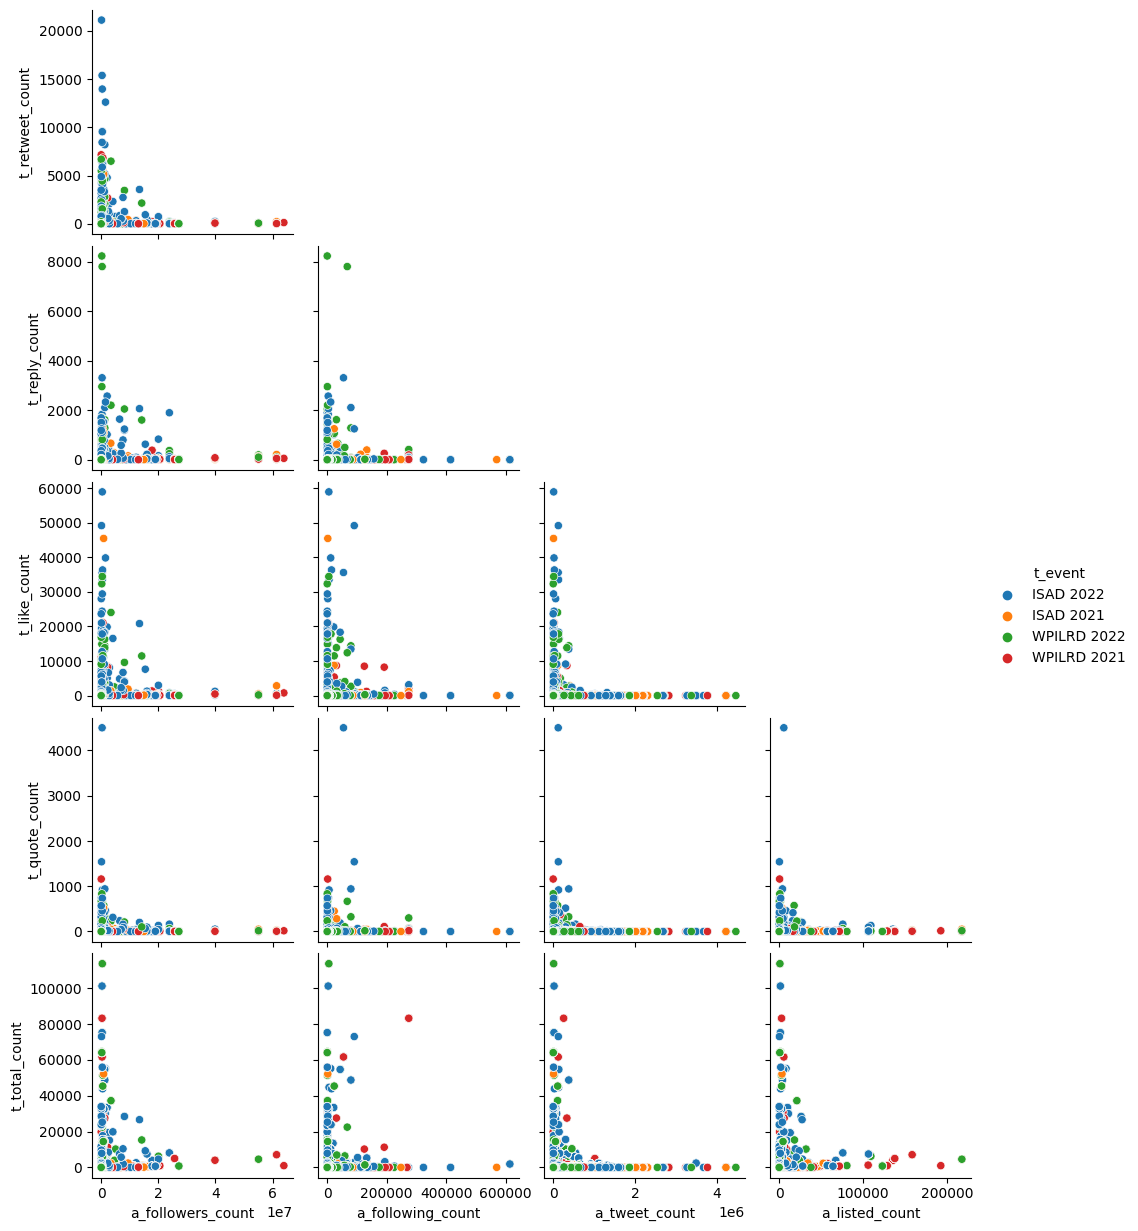

In [33]:
sns.pairplot(df, 
             y_vars=['t_retweet_count','t_reply_count', 't_like_count', 't_quote_count', 't_total_count'], 
             x_vars =df.groupby('a_id')[['a_followers_count', 'a_following_count', 'a_tweet_count', 'a_listed_count']].max(), 
             hue='t_event', 
             corner=True)

In [34]:
nth_largest = 2
mask_t_largest = ((df['t_reply_count'].isin(df['t_reply_count'].nlargest(nth_largest))) | 
(df['t_like_count'].isin(df['t_like_count'].nlargest(nth_largest))) |
(df['t_quote_count'].isin(df['t_quote_count'].nlargest(nth_largest))) |
(df['t_retweet_count'].isin(df['t_retweet_count'].nlargest(nth_largest))))

df[mask_t_largest][['a_name', 't_text', 't_retweet_count',	't_reply_count', 	't_like_count', 	't_quote_count']]

a_name                                             t_text  \
15237      Texas Tribune  Texas Attorney General Ken Paxton fled his hom...   
15970  Chip Franklin.com  What do you call a “Pro-Life Christian” who vo...   
66857   Gretchen Whitmer                   Abortion is a fundamental right.   
74552  Olivia Julianna 🗳  Considering Ken Paxton is attempting to block ...   
82729               𝐁𝐞𝐤𝐬  Two more pregnant children who were raped were...   

       t_retweet_count  t_reply_count  t_like_count  t_quote_count  
15237            15374           3307         35566           4500  
15970             1627           7797         12377            667  
66857             4636           8225         32305            833  
74552            13962            464         58868            318  
82729            21108           1246         49117           1540

In [35]:
#df = df[~mask_t_largest]

In [36]:
nth_largest_followers = 3
nth_largest_following = 2

mask_a_largest = ((df['a_followers_count'].isin(df['a_followers_count'].nlargest(nth_largest_followers))) | 
(df['a_following_count'].isin(df['a_following_count'].nlargest(nth_largest_following)))) 
#(df['a_tweet_count'].isin(df['a_tweet_count'].nlargest(nth_largest))) |
#(df['a_listed_count'].isin(df['a_listed_count'].nlargest(nth_largest))))

df[mask_a_largest].size

1344

In [37]:
df[mask_a_largest]['a_name'].value_counts()#[['a_name', 't_text', 't_retweet_count',	't_reply_count', 	't_like_count', 	't_quote_count']]

a_name
Jeffrey Levin 🇺🇦     52
CNN                  11
CNN Breaking News     1
Name: count, dtype: int64

In [39]:
#df = df[~mask_a_largest]

In [40]:
print(len(df['t_id'].unique()))
print(len(df['a_id'].unique()))

89786
52424


The final dataset side for analysis is therefore composed of 80244 tweets and 47889 authors

# Running models

## Data preparation

### Normalisation
The data are only positive and heavily skewed on the right. In this case it is better to use normalisation rather than standardisation. The step is required to help the models to convergeimport MinMaxScalerimport MinMaxScaler

In [41]:
# Standarise the predictors

# Extract the predictor variables and the response variable
predictors = ['a_followers_count', 'a_following_count', 'a_tweet_count', 'a_listed_count']
X = df[predictors]

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the predictor variables
df[[f"{col}_stand" for col in X.columns]] = scaler.fit_transform(X)

### Factoring the different columns

In [42]:
%%R -i df -o df_R
# Refactoring 
df$a_id <- as.factor(df$a_id)
df$t_year <- as.factor(df$t_year)
df$t_type_event <- as.factor(df$t_type_event)
df_R <- df

/home/olivier/git/pro/bsc/MiscarriageTwitterAnalysis/.venv/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "a_id". Fall back to string conversion. The error is: integer 2147874998 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '


## Hypothesis 1

* H1. Do men and women have different discussions and/or opinions surrounding Miscarriage and Abortion
* H1.1 Men will tend to talk more about Abortion than Miscarriage 
* H1.2 Women will tend to have more subjective and polarized tweets than men
* H1.3 The subjectivity and polarity will be exacerbated in the case of miscarriage


### H.1.1.


To answer the H.1. we need to choose between the total of tweets per gender or the presence of unique users. 
In case of the presence of unique users we chose to include in our test each user only once but per event and per year. Each user can be present in Miscarriage, Abortion dataset, in 2021 and in 2022 but not more than once in each of this condition


In [175]:
df_gender_event_unique = df.groupby(['a_gender', 't_type_event', 't_year', 'a_id']).size().reset_index()[['a_gender', 't_type_event', 't_year']].rename(columns={'a_gender': 'Gender', 't_type_event': 'Event', 't_year': 'Year'})
#.groupby(['a_gender', 't_type_event']).sum().reset_index()[['a_gender', 't_type_event', 't_year', 0]].rename(columns={0: 'Count', 'a_gender': 'Gender', 't_type_event': 'Event', 't_year': 'Year'})
df_gender_event_unique = df_gender_event_unique[df_gender_event_unique['Gender'] != 'neutral']

#### Logistic regression

In [188]:
df_gender_log = pd.get_dummies(df_gender_event_unique, columns=["Gender", "Event", 'Year'], drop_first=False)
df_gender_log = df_gender_log.replace({True: 1, False: 0})
X = df_gender_log[["Event_Abortion", 'Year_2021']]

y = df_gender_log["Gender_female"]
X = sm.add_constant(X)  # Add a constant term for the intercept
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())
#result.summary.to_csv('./results/tables/gender_event_log.csv', index=False)
#result.summary()

Optimization terminated successfully.
         Current function value: 0.630046
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          Gender_female   No. Observations:                43382
Model:                          Logit   Df Residuals:                    43379
Method:                           MLE   Df Model:                            2
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:               0.0009244
Time:                        16:41:45   Log-Likelihood:                -27333.
converged:                       True   LL-Null:                       -27358.
Covariance Type:            nonrobust   LLR p-value:                 1.039e-11
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7224      0.018     40.687      0.000       0.688       0.757
Event_Abortion   

#### Chisquare test

In [177]:
from scipy.stats import chi2_contingency
from scipy.stats import norm
def chisq_posthoc_corrected(cross_table, correction_method='bonferroni', alpha=.05):
    """
    Get crosstab dataframe and do a chisquared test followed with the post-hoc with analysis of adjusted residuals
    source: https://colab.research.google.com/drive/1QIDHMvpDq7Max5hk2mozSFdVssavdV-I#scrollTo=ig1kdg40qLDH
    source: https://github.com/neuhofmo/chisq_test_wrapper
    """
    def get_asterisks_for_pval(p_val, alpha=0.05):
        """Receives the p-value and returns asterisks string."""
        if p_val > alpha:  # bigger than alpha
            p_text = "ns"
        # following the standards in biological publications
        elif p_val < 1e-4:  
            p_text = '****'
        elif p_val < 1e-3:
            p_text = '***'
        elif p_val < 1e-2:
            p_text = '**'
        else:
            p_text = '*'
    
        return p_text  # string of asterisks
    
    chiVal, pVal, df, exp = chi2_contingency(cross_table)

    colTotals = cross_table.sum()
    nCols = len(colTotals)
    rowTotals = cross_table.sum(axis=1)
    nRows = len(rowTotals)
    n = sum(rowTotals)
    print("Chi2 result of the contingency table: {}, p-value: {}, dof: {}, N: {}\n".format(chiVal, pVal, df, n))

    
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5            
    phRes = pd.DataFrame(columns=[cross_table.index.name, cross_table.columns.name, 'Adj. Res.'])
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5
            phRes = phRes.append({cross_table.index.name:cross_table.index[i], cross_table.columns.name:cross_table.columns[j], 'Adj. Res.':AdjRes}, ignore_index=True)
    phRes['p_value'] = 2*(1-norm.cdf(abs(phRes['Adj. Res.'])))
    # Bonferroni correction
  
    reject_list, corrected_p_vals = multipletests(phRes['p_value'], method=correction_method, alpha=alpha)[:2]
    
    phRes['p_value_corrected'] = corrected_p_vals
    phRes['reject'] = reject_list
    ast = []
    for p_vals in corrected_p_vals:
        ast.append(get_asterisks_for_pval(p_vals))
    phRes['asterisques'] = ast

    return phRes

### H.1.2.
* H1.2 Women will tend to have more subjective and polarized tweets than men. 


In [196]:
%%R -i df_R -o df_R_gender
## Filtering the neutral gender
df_R_gender <- df_R %>%  filter(a_gender !='neutral')

In [198]:
%%R -i df_R_gender -o m_pol_gender
m_formula =  paste0('t_polarity ~ ',
                    'a_gender',
                    ' + t_type_event',
                    ' + t_year',
                    ' + (1 | a_id)')
m_pol_gender <- lmer(m_formula, data=df_R_gender)
print(summary(m_pol_gender))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: m_formula
   Data: df_R_gender

REML criterion at convergence: 37750.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8576 -0.7732  0.0854  0.6839  4.4316 

Random effects:
 Groups   Name        Variance Std.Dev.
 a_id     (Intercept) 0.03234  0.1798  
 Residual             0.08686  0.2947  
Number of obs: 56807, groups:  a_id, 38216

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             -3.028e-01  3.109e-03  4.723e+04 -97.398  < 2e-16 ***
a_gendermale            -4.927e-03  3.496e-03  3.089e+04  -1.410   0.1587    
t_type_eventMiscarriage -6.300e-03  2.930e-03  5.680e+04  -2.150   0.0315 *  
t_year2022              -1.811e-02  3.113e-03  5.462e+04  -5.819 5.97e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) a_gndr t_ty_M
a_gendermal -0.

In [199]:
%%R -i df_R_gender -o m_sub_gender
m_formula =  paste0('t_subjectivity ~ ',
                    'a_gender',
                    ' + t_type_event',
                    ' + t_year',
                    ' + (1 | a_id)')
m_sub_gender <- lmer(m_formula, data=df_R_gender)
print(summary(m_sub_gender))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: m_formula
   Data: df_R_gender

REML criterion at convergence: 20545.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.04279 -0.98107  0.04617  0.63933  3.02958 

Random effects:
 Groups   Name        Variance Std.Dev.
 a_id     (Intercept) 0.01189  0.1091  
 Residual             0.07342  0.2710  
Number of obs: 56807, groups:  a_id, 38216

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              3.463e-01  2.602e-03  4.460e+04 133.052  < 2e-16 ***
a_gendermale            -5.581e-03  2.856e-03  2.997e+04  -1.954   0.0507 .  
t_type_eventMiscarriage -5.005e-03  2.510e-03  5.609e+04  -1.994   0.0462 *  
t_year2022               1.709e-02  2.639e-03  5.187e+04   6.478 9.38e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) a_gndr t_ty_M
a_gen

## Total Count

In [ ]:
%%R -i df_R -o m_total_main_zero
## ZERO INFLATED POISSON
m_formula =  paste0('t_total_count ~ ',
                    't_subjectivity',
                    ' + t_polarity',
                    ' + t_type_event',
                    ' + t_year',
                    ' + a_following_count_stand',
                    ' + a_tweet_count_stand',
                    ' + a_listed_count_stand',
                    ' + a_followers_count_stand',
                    ' + (1 | a_id)')
m_total_main_zero <- glmmTMB(t_total_count ~  t_polarity + t_subjectivity  + t_type_event + t_year + a_following_count_stand +  a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = poisson
                            )
print(summary(m_total_main_zero))

In [ ]:
%%R -i m_total_main_zero -o m_total_inter_zero
# Specify the type of data in the df to avoid conversion issues

m_total_inter_zero <- update(m_total_main_zero, . ~ .  + t_subjectivity*t_polarity + t_polarity*t_type_event)

print(summary(m_retweet_inte))

## Retweet count

### Main effects

In [ ]:
%%R -i df_R -o m_retweet_main_zero
## ZERO INFLATED POISSON
#+ a_following_count_stand +  a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand
m_retweet_main_zero <- glmmTMB(t_retweet_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )
print(summary(m_retweet_main_zero))

### Interaction effects

### Model selection

In [ ]:
%%R 
m_retweet_simple_zero <- glmmTMB(t_retweet_count ~  a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )


m_retweet_main_zero <- glmmTMB(t_retweet_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )

m_retweet_inter_zero <- glmmTMB(t_retweet_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + t_subjectivity*t_polarity + t_polarity*t_type_event + t_subjectivity*t_type_event + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )
anova_result <- anova(m_retweet_simple_zero, m_retweet_main_zero, m_retweet_inter_zero)
anova_result

### Analyse selected model

In [ ]:
%%R -i m_retweet_inte
confint(m_retweet_inte)

In [ ]:
%%R -i df
df %>% ggplot(aes(t_retweet_count, t_polarity)) + 
  geom_point(size=0.5) + 
  geom_smooth(aes(group=t_event, color=t_event), method="lm")

## Reply count

### Main effects

In [ ]:
%%R 
m_reply_simple_zero <- glmmTMB(t_reply_count ~  a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )


m_reply_main_zero <- glmmTMB(t_reply_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )

m_reply_inter_zero <- glmmTMB(t_reply_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + t_subjectivity*t_polarity + t_polarity*t_type_event + t_subjectivity*t_type_event + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )
anova_result <- anova(m_reply_simple_zero, m_reply_main_zero, m_reply_inter_zero)
anova_result

In [ ]:
%%R -i df -o m_reply_main
# Specify the type of data in the df to avoid conversion issues

df$a_id <- as.factor(df$a_id)
df$t_year <- as.factor(df$t_year)
df$t_type_event <- as.factor(df$t_type_event)

m_formula =  paste0('t_reply_count ~ ',
                    't_subjectivity',
                    ' + t_polarity',
                    ' + t_type_event', 
                    ' + t_year',
                    ' + a_following_count_stand',
                    ' + a_tweet_count_stand',
                    ' + a_listed_count_stand',
                    ' + a_followers_count_stand',
                    ' + (1 | a_id)')
m_reply_main <- lmer(m_formula, data=df)
print(summary(m_reply_main))

### Interaction effects

In [ ]:
%%R -i m_reply_main -o m_reply_inte
# Specify the type of data in the df to avoid conversion issues

m_reply_inte <- update(m_reply_main, . ~ .  + t_subjectivity*t_polarity + t_polarity*t_type_event)

print(summary(m_reply_inte))

### Model selection

In [ ]:
%%R -i m_reply_main m_reply_inte

anova_result <- anova(m_reply_main, m_reply_inte)
anova_result

## Like count

In [ ]:
%%R 
m_like_simple_zero <- glmmTMB(t_like_count ~  a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )


m_like_main_zero <- glmmTMB(t_like_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )

m_like_inter_zero <- glmmTMB(t_like_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + t_subjectivity*t_polarity + t_polarity*t_type_event + t_subjectivity*t_type_event + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )
anova_result <- anova(m_like_simple_zero, m_like_main_zero, m_like_inter_zero)
anova_result

### Main effects

In [ ]:
%%R -i df -o m_like_main
# Specify the type of data in the df to avoid conversion issues

df$a_id <- as.factor(df$a_id)
df$t_year <- as.factor(df$t_year)
df$t_type_event <- as.factor(df$t_type_event)

m_formula =  paste0('t_like_count ~ ',
                    't_subjectivity',
                    ' + t_polarity',
                    ' + t_type_event',
                    ' + t_year',
                    ' + a_following_count_stand',
                    ' + a_tweet_count_stand',
                    ' + a_listed_count_stand',
                    ' + a_followers_count_stand',
                    ' + (1 | a_id)')
m_like_main <- lmer(m_formula, data=df)
print(summary(m_like_main))

### Interaction effects

In [ ]:
%%R -i m_like_main -o m_like_inte
# Specify the type of data in the df to avoid conversion issues

m_like_inte <- update(m_like_main, . ~ .  + t_subjectivity*t_polarity + t_polarity*t_type_event)

print(summary(m_like_inte))

### Model selection

In [ ]:
%%R -i m_like_main m_like_inte

anova_result <- anova(m_like_main, m_like_inte)
anova_result

## Quote count

In [ ]:
%%R 
m_quote_simple_zero <- glmmTMB(t_quote_count ~  a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )


m_quote_main_zero <- glmmTMB(t_quote_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )

m_quote_inter_zero <- glmmTMB(t_quote_count ~  t_polarity + t_subjectivity  + t_type_event + t_year  + a_following_count_stand + a_tweet_count_stand + a_listed_count_stand + a_followers_count_stand + t_subjectivity*t_polarity + t_polarity*t_type_event + t_subjectivity*t_type_event + (1| a_id), 
                             data=df_R, 
                             ziformula = ~1, 
                             family = truncated_poisson(link = "log")
                            )
anova_result <- anova(m_quote_simple_zero, m_quote_main_zero, m_quote_inter_zero)
anova_result

### Main effects

In [ ]:
%%R -i df -o m_quote_main
# Specify the type of data in the df to avoid conversion issues

df$a_id <- as.factor(df$a_id)
df$t_year <- as.factor(df$t_year)
df$t_type_event <- as.factor(df$t_type_event)

m_formula =  paste0('t_quote_count ~ ',
                    't_subjectivity',
                    ' + t_polarity',
                    ' + t_type_event',
                    ' + t_year',
                    ' + a_following_count_stand',
                    ' + a_tweet_count_stand',
                    ' + a_listed_count_stand',
                    ' + a_followers_count_stand',
                    ' + (1 | a_id)')
m_quote_main <- lmer(m_formula, data=df)
print(summary(m_quote_main))

### Interaction effects

In [ ]:
%%R -i m_quote_main -o m_quote_inte
# Specify the type of data in the df to avoid conversion issues

m_quote_inte <- update(m_quote_main, . ~ .  + t_subjectivity*t_polarity + t_polarity*t_type_event)

print(summary(m_quote_inte))

### Model selection

In [ ]:
%%R -i m_quote_main m_quote_inte

anova_result <- anova(m_quote_main, m_quote_inte)
anova_result

### H4

In [230]:
df[(df['t_depression'] != 'not depression')].groupby(['t_topic_label']).size().sort_values(ascending=False)#.reset_index()

t_topic_label
-1_social_creating_free_society_aim_world_marriage_protect_reproductive_evil                    85
0_body_choice_fucking_prison_oklahoma_vaccine_yall_men_pro_black                                71
5_loss_infant_stillbirth_awareness_lost_light_miscarriage_experience_october_regret             23
1_medicare_cut_immediately_teaching_ad_lose_congress_beginning_economy_restrict                 17
55_saved_trash_store_bunch_dy_aborted_car_buy_far_thinking                                      10
2_unsafe_medication_international_accessible_safe_essential_barrier_stigma_medicine_maternal     9
4_catholic_christian_god_jesus_church_bible_harris_nancy_sin_pastor                              9
15_funding_funded_donate_fund_cost_extremist_money_wearing_defund_bit                            4
30_film_movie_industry_director_tw_sad_came_abusive_innocent_propaganda                          3
60_posted_miscarriage_gross_pill_racist_dick_fr_shocking_reasonable_justice                    